In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
import pandas as pd

ruta = r"C:\Users\Yudith\Desktop\Análisis de Datos\MACHINE LEARNING\NUEVO PROYECTO YUDI\dataset_pedidos_1.csv"
data = pd.read_csv(ruta, encoding="utf-8-sig")

print(data.head())


   id_pedido  id_cliente categoria_producto            producto  cantidad  \
0       4147          23           Deportes  Camiseta deportiva         2   
1       3589         732        Electrónica          Smartwatch         1   
2        178         771             Libros       Libro técnico         1   
3       3283         912             Libros       Libro técnico         4   
4       1674         286             Libros           Biografía         3   

   precio_unitario  descuento  tiempo_entrega_dias  calificacion  \
0           323.44      0.129                    5          3.08   
1           387.75      0.140                    4          3.63   
2            19.56      0.070                    8          4.61   
3            80.00      0.042                    8          4.01   
4            33.68      0.017                    7          3.47   

   ingreso_total      metodo_pago       pais        subregion  \
0         563.43   Tarjeta Débito  Guatemala  Central America  

Convertir la fecha

In [45]:
 data["fecha_pedido"] = pd.to_datetime(data["fecha_pedido"])


Crear periodo mensual

In [46]:
data["mes"] = data["fecha_pedido"].dt.to_period("M")


Agregar ventas por mes

In [47]:
serie_ventas = (
    data
    .groupby("mes")["ingreso_total"]
    .sum()
    .reset_index()
)


Convertir a fecha real

In [48]:
serie_ventas["fecha"] = serie_ventas["mes"].dt.to_timestamp()


Limpiar columnas

In [49]:
serie_ventas = serie_ventas[["fecha", "ingreso_total"]]
serie_ventas.columns = ["fecha", "ventas"]


In [50]:
print(serie_ventas.head())
print("Cantidad de meses:", len(serie_ventas))


       fecha     ventas
0 2023-01-01  102565.56
1 2023-02-01   79613.09
2 2023-03-01  108879.35
3 2023-04-01  101375.14
4 2023-05-01  114572.66
Cantidad de meses: 24


Gráfico diagnóstico

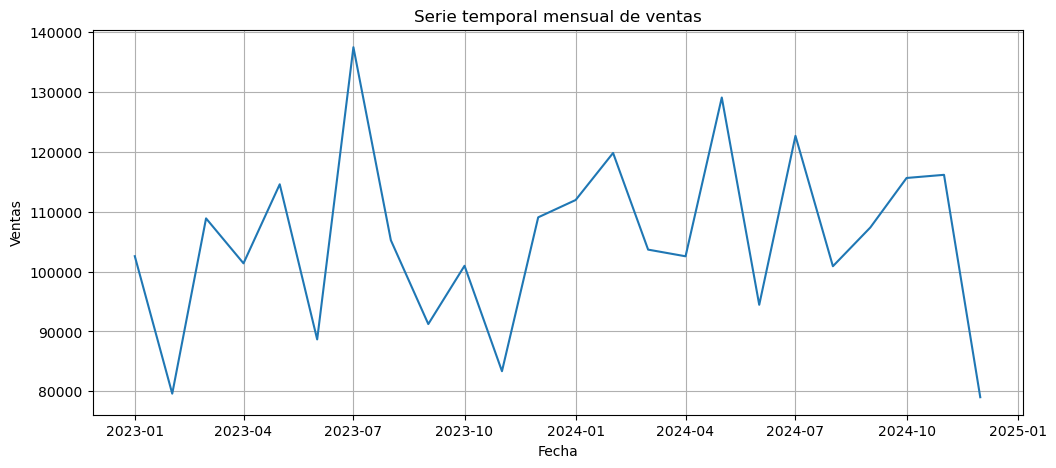

In [51]:
plt.figure(figsize=(12,5))
plt.plot(serie_ventas["fecha"], serie_ventas["ventas"])
plt.title("Serie temporal mensual de ventas")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.grid(True)
plt.show()


Baseline naïve dice:

“si el modelo no mejora esto, no sirve”.


In [52]:
# último valor como predicción futura
baseline_forecast = [serie_ventas["ventas"].iloc[-1]] * 12

print("Baseline (último valor):", baseline_forecast[0])


Baseline (último valor): 79016.35


In [53]:
pip install statsmodels


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: statsmodels in c:\users\yudith\onedrive\documentos\lib\site-packages (0.14.5)



Exponential Smoothing (Holt-Winters)
modelo más adecuado para pocas observaciones.

In [54]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_hw = ExponentialSmoothing(
    train["ventas"],
    trend="add",
    seasonal=None
)

fit_hw = model_hw.fit()


Predicción test

In [ ]:
pred_test = fit_hw.forecast(len(test))


Evaluar

AUTOCORRELACIÓN (MUY IMPORTANTE)

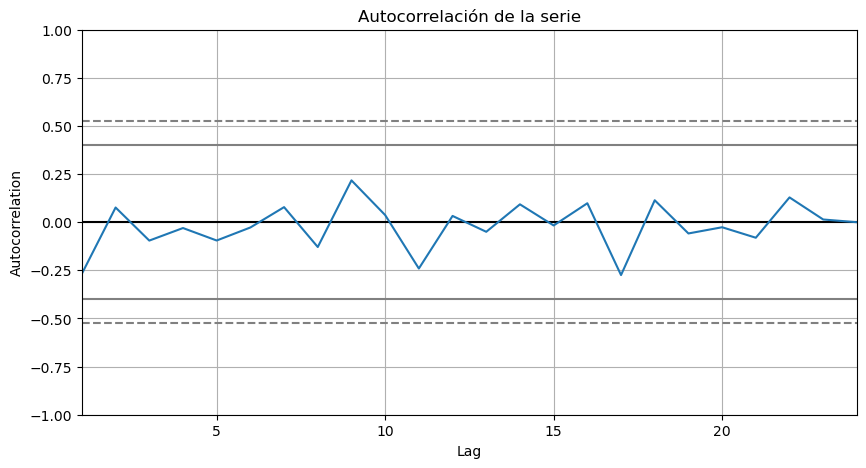

In [58]:
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
autocorrelation_plot(serie_ventas["ventas"])
plt.title("Autocorrelación de la serie")
plt.grid(True)
plt.show()


Forecast final a 12 meses

In [59]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_final = ExponentialSmoothing(
    serie_ventas["ventas"],
    trend="add",
    seasonal=None
)

fit_final = model_final.fit()

forecast_12 = fit_final.forecast(12)


Crear fechas futuras

In [60]:
fechas_futuras = pd.date_range(
    start=serie_ventas["fecha"].iloc[-1] + pd.DateOffset(months=1),
    periods=12,
    freq="MS"
)


Crear escenarios (MUY IMPORTANTE)

Usamos el error del modelo como incertidumbre.

In [61]:
error_std = (serie_ventas["ventas"] - fit_final.fittedvalues).std()

forecast_base = forecast_12
forecast_optimista = forecast_12 + error_std
forecast_pesimista = forecast_12 - error_std


DataFrame final

In [62]:
Fact_Forecast = pd.DataFrame({
    "fecha": fechas_futuras,
    "ventas_forecast": forecast_base,
    "upper_bound": forecast_optimista,
    "lower_bound": forecast_pesimista
})


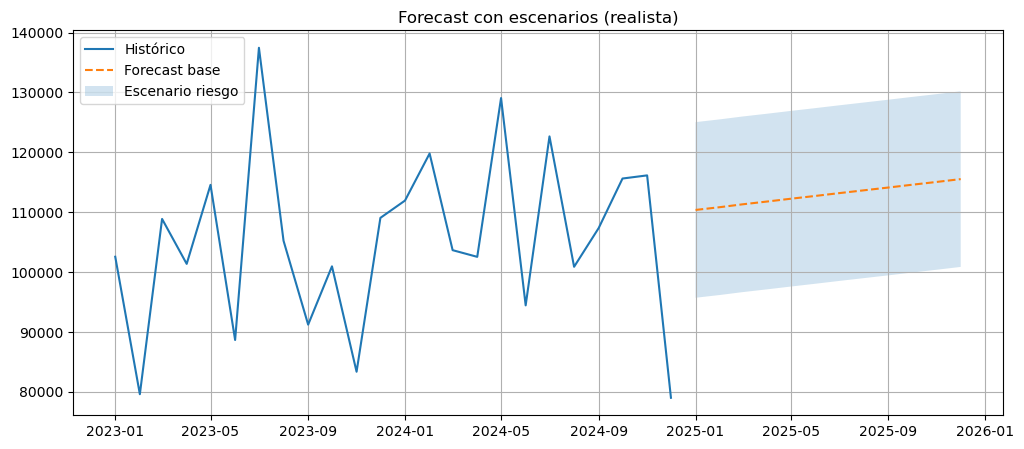

In [71]:
plt.figure(figsize=(12,5))

# histórico
plt.plot(
    serie_ventas["fecha"],
    serie_ventas["ventas"],
    label="Histórico"
)

# forecast base
plt.plot(
    Fact_Forecast["fecha"],
    Fact_Forecast["ventas_forecast"],
    linestyle="--",
    label="Forecast base"
)

# intervalo
plt.fill_between(
    Fact_Forecast["fecha"],
    Fact_Forecast["lower_bound"],
    Fact_Forecast["upper_bound"],
    alpha=0.2,
    label="Escenario riesgo"
)

plt.title("Forecast con escenarios (realista)")
plt.legend()
plt.grid(True)
plt.show()


El nivel esperado es relativamente estable, pero hay alta incertidumbre

KPI AUTOMÁTICOS

In [64]:
# tendencia esperada
tendencia_pct = (
    (Fact_Forecast["ventas_forecast"].mean() -
     serie_ventas["ventas"].tail(12).mean())
    / serie_ventas["ventas"].tail(12).mean()
) * 100

# volatilidad histórica
volatilidad = serie_ventas["ventas"].std()

# riesgo relativo
riesgo_pct = volatilidad / serie_ventas["ventas"].mean() * 100

print("Tendencia esperada:", round(tendencia_pct,2), "%")
print("Riesgo histórico:", round(riesgo_pct,2), "%")


Tendencia esperada: 4.01 %
Riesgo histórico: 14.0 %


Se espera mantener ventas con ligera expansión.

CLASIFICACIÓN AUTOMÁTICA

In [65]:
# ==========================
# Clasificación automática
# ==========================

# tendencia
if tendencia_pct > 5:
    estado_tendencia = "Crecimiento"
elif tendencia_pct < -5:
    estado_tendencia = "Caída"
else:
    estado_tendencia = "Estable"

# riesgo
if riesgo_pct < 8:
    nivel_riesgo = "Bajo"
elif riesgo_pct < 12:
    nivel_riesgo = "Medio"
else:
    nivel_riesgo = "Alto"

print("Estado tendencia:", estado_tendencia)
print("Nivel de riesgo:", nivel_riesgo)


Estado tendencia: Estable
Nivel de riesgo: Alto


In [66]:
# ==========================
# Mensaje ejecutivo automático
# ==========================

if estado_tendencia == "Crecimiento":
    mensaje_tendencia = "Se espera crecimiento moderado de ventas."
elif estado_tendencia == "Caída":
    mensaje_tendencia = "Se observa tendencia bajista. Revisar estrategia comercial."
else:
    mensaje_tendencia = "Las ventas se mantienen estables."

if nivel_riesgo == "Alto":
    mensaje_riesgo = "Alta volatilidad histórica: usar planificación flexible."
elif nivel_riesgo == "Medio":
    mensaje_riesgo = "Variabilidad moderada en las ventas."
else:
    mensaje_riesgo = "Comportamiento estable y predecible."

mensaje_final = f"""
Forecast Ejecutivo:
• Tendencia: {estado_tendencia} ({round(tendencia_pct,2)}%)
• Riesgo: {nivel_riesgo} ({round(riesgo_pct,1)}%)
• Insight: {mensaje_tendencia}
• Recomendación: {mensaje_riesgo}
"""

print(mensaje_final)



Forecast Ejecutivo:
• Tendencia: Estable (4.01%)
• Riesgo: Alto (14.0%)
• Insight: Las ventas se mantienen estables.
• Recomendación: Alta volatilidad histórica: usar planificación flexible.



Dashboard completo

In [72]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [73]:
fig = make_subplots(
    rows=2, cols=2,
    specs=[
        [{"colspan": 2}, None],
        [{"type": "indicator"}, {"type": "indicator"}]
    ],
    subplot_titles=[
        "Ventas Históricas y Forecast (12 meses)",
        "Tendencia Esperada",
        "Nivel de Riesgo"
    ],
    vertical_spacing=0.18
)

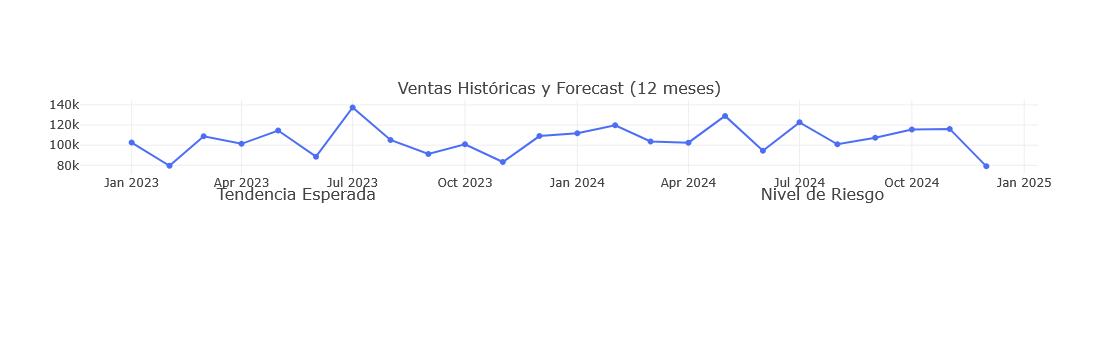

In [74]:
fig.add_trace(
    go.Scatter(
        x=serie_ventas["fecha"],
        y=serie_ventas["ventas"],
        mode="lines+markers",
        name="Histórico",
        line=dict(color="#4C6EF5", width=2)
    ),
    row=1, col=1
)

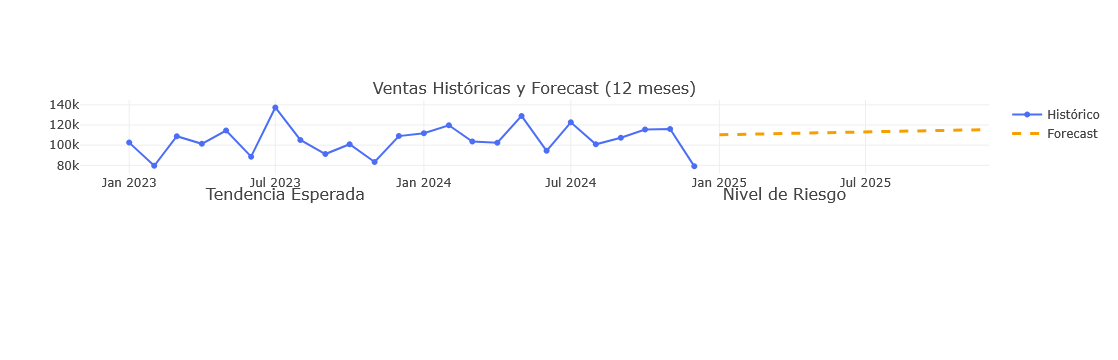

In [75]:
fig.add_trace(
    go.Scatter(
        x=Fact_Forecast["fecha"],
        y=Fact_Forecast["ventas_forecast"],
        mode="lines",
        name="Forecast",
        line=dict(color="#F59F00", dash="dash", width=3)
    ),
    row=1, col=1
)

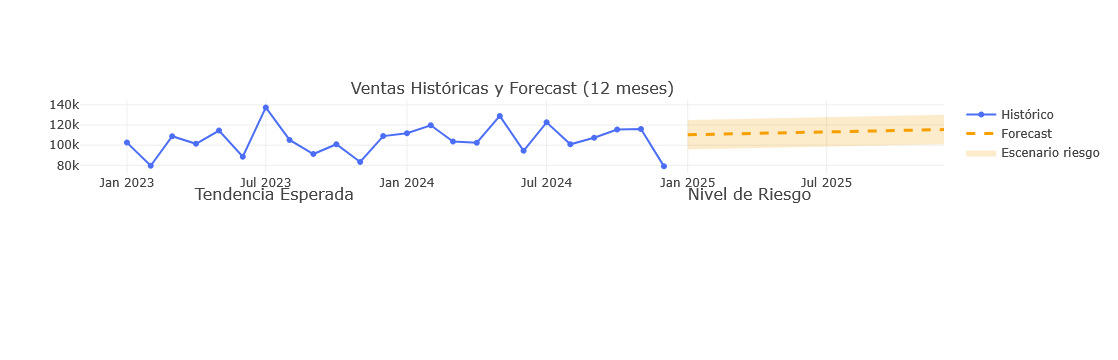

In [76]:
fig.add_trace(
    go.Scatter(
        x=list(Fact_Forecast["fecha"]) + list(Fact_Forecast["fecha"][::-1]),
        y=list(Fact_Forecast["upper_bound"]) + list(Fact_Forecast["lower_bound"][::-1]),
        fill="toself",
        fillcolor="rgba(245,159,0,0.20)",
        line=dict(color="rgba(255,255,255,0)"),
        hoverinfo="skip",
        name="Escenario riesgo"
    ),
    row=1, col=1
)


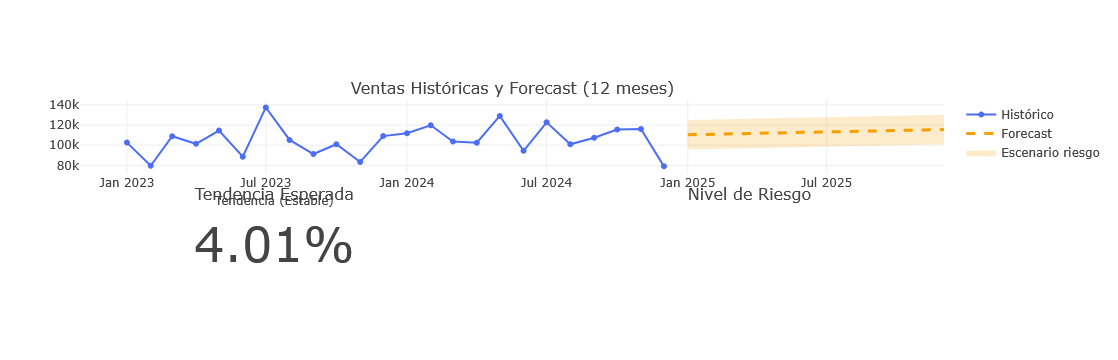

In [77]:
fig.add_trace(
    go.Indicator(
        mode="number",
        value=tendencia_pct,
        number={"suffix": "%", "font": {"size": 48}},
        title={"text": f"Tendencia ({estado_tendencia})"},
    ),
    row=2, col=1
)

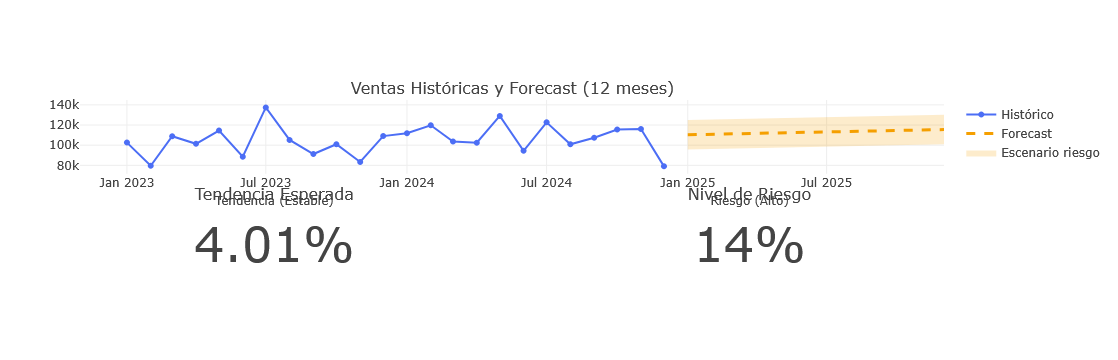

In [78]:
fig.add_trace(
    go.Indicator(
        mode="number",
        value=riesgo_pct,
        number={"suffix": "%", "font": {"size": 48}},
        title={"text": f"Riesgo ({nivel_riesgo})"},
    ),
    row=2, col=2
)


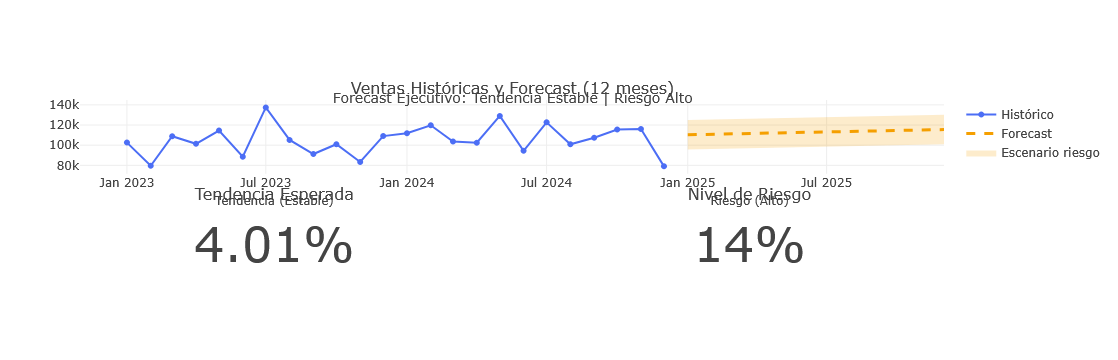

In [79]:
fig.add_annotation(
    text=f"Forecast Ejecutivo: Tendencia {estado_tendencia} | Riesgo {nivel_riesgo}",
    x=0.5,
    y=1.08,
    xref="paper",
    yref="paper",
    showarrow=False,
    font=dict(size=14)
)

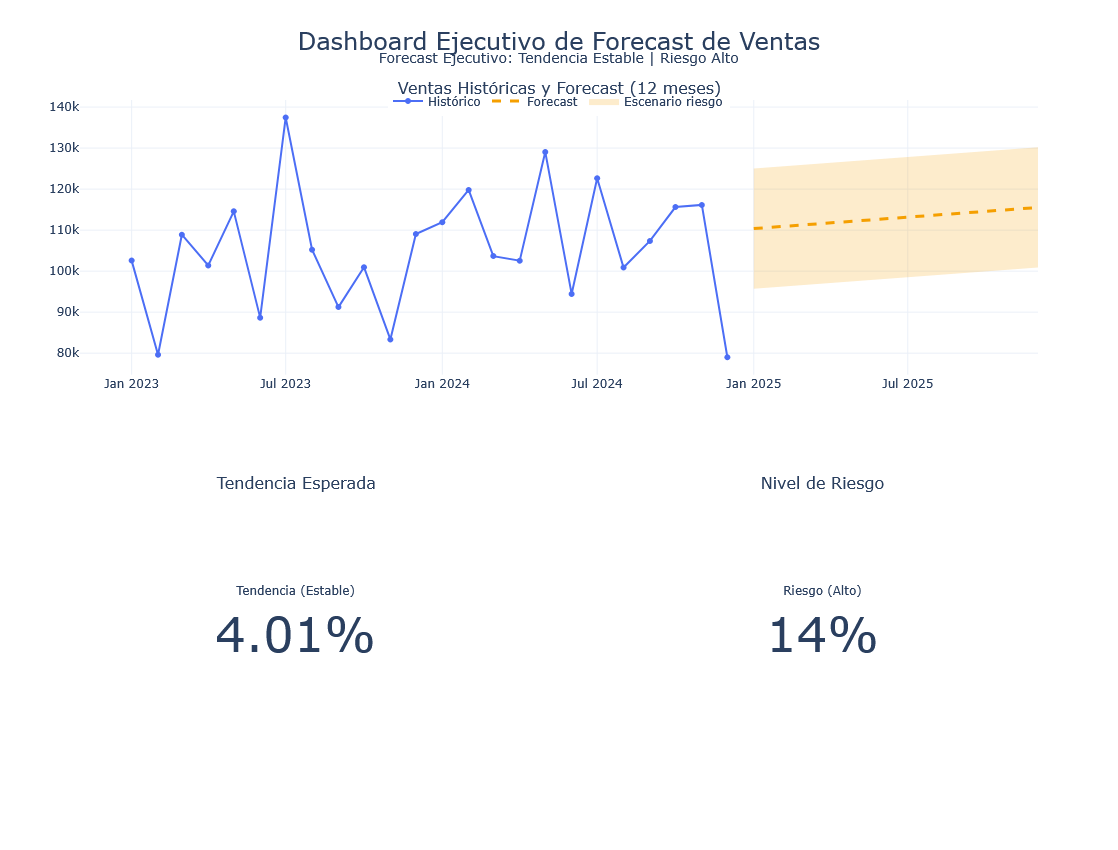

In [80]:
fig.update_layout(
    height=850,
    width=1200,
    title=dict(
        text="Dashboard Ejecutivo de Forecast de Ventas",
        x=0.5,
        font=dict(size=24)
    ),
    template="plotly_white",
    showlegend=True,
    legend=dict(
        orientation="h",
        y=1.02,
        x=0.5,
        xanchor="center"
    )
)

fig.show()


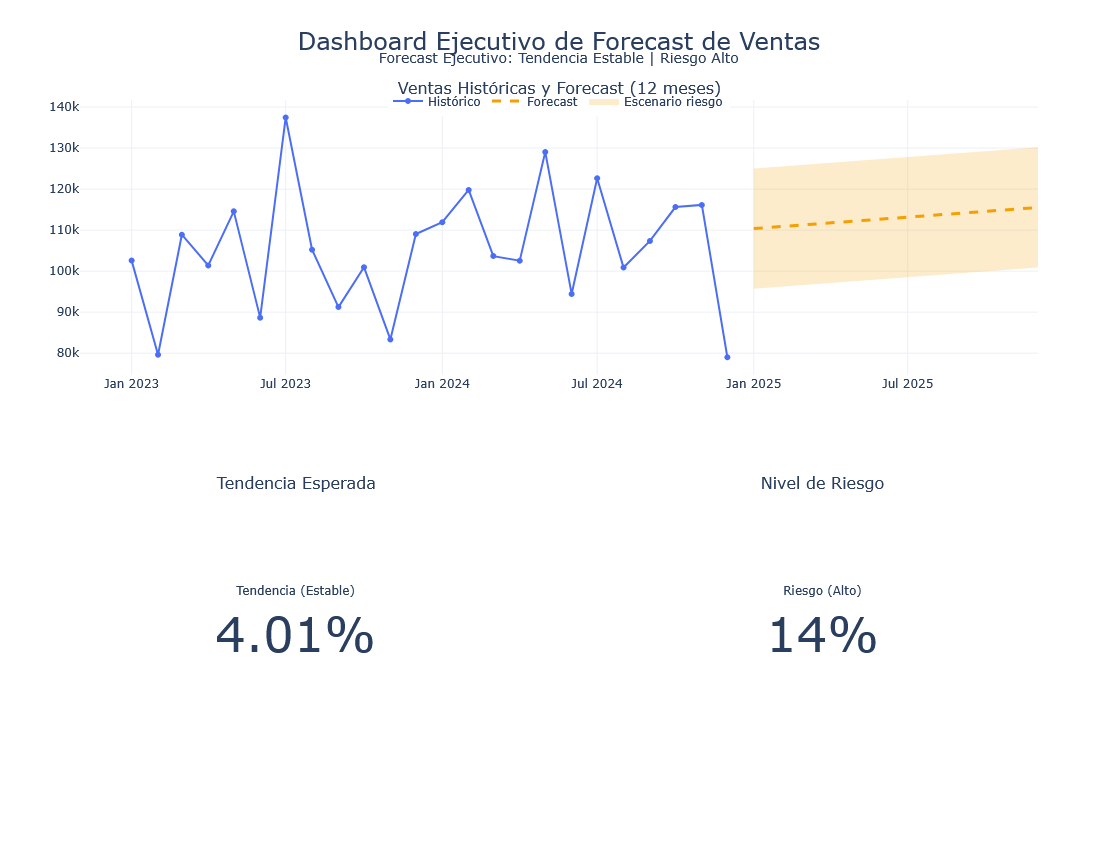

In [67]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ==========================
# 🔹 Crear Dashboard
# ==========================

fig = make_subplots(
    rows=2, cols=2,
    specs=[
        [{"colspan": 2}, None],
        [{"type": "indicator"}, {"type": "indicator"}]
    ],
    subplot_titles=[
        "Ventas Históricas y Forecast (12 meses)",
        "Tendencia Esperada",
        "Nivel de Riesgo"
    ],
    vertical_spacing=0.18
)

# ==========================
# 📈 Histórico
# ==========================

fig.add_trace(
    go.Scatter(
        x=serie_ventas["fecha"],
        y=serie_ventas["ventas"],
        mode="lines+markers",
        name="Histórico",
        line=dict(color="#4C6EF5", width=2)
    ),
    row=1, col=1
)

# ==========================
# 📈 Forecast
# ==========================

fig.add_trace(
    go.Scatter(
        x=Fact_Forecast["fecha"],
        y=Fact_Forecast["ventas_forecast"],
        mode="lines",
        name="Forecast",
        line=dict(color="#F59F00", dash="dash", width=3)
    ),
    row=1, col=1
)

# ==========================
# 🌫️ Banda de riesgo
# ==========================

fig.add_trace(
    go.Scatter(
        x=list(Fact_Forecast["fecha"]) + list(Fact_Forecast["fecha"][::-1]),
        y=list(Fact_Forecast["upper_bound"]) + list(Fact_Forecast["lower_bound"][::-1]),
        fill="toself",
        fillcolor="rgba(245,159,0,0.20)",
        line=dict(color="rgba(255,255,255,0)"),
        hoverinfo="skip",
        name="Escenario riesgo"
    ),
    row=1, col=1
)

# ==========================
# 📊 KPI Tendencia
# ==========================

fig.add_trace(
    go.Indicator(
        mode="number",
        value=tendencia_pct,
        number={"suffix": "%", "font": {"size": 48}},
        title={"text": f"Tendencia ({estado_tendencia})"},
    ),
    row=2, col=1
)

# ==========================
# 📉 KPI Riesgo
# ==========================

fig.add_trace(
    go.Indicator(
        mode="number",
        value=riesgo_pct,
        number={"suffix": "%", "font": {"size": 48}},
        title={"text": f"Riesgo ({nivel_riesgo})"},
    ),
    row=2, col=2
)

# ==========================
# 📝 Mensaje ejecutivo
# ==========================

fig.add_annotation(
    text=f"Forecast Ejecutivo: Tendencia {estado_tendencia} | Riesgo {nivel_riesgo}",
    x=0.5,
    y=1.08,
    xref="paper",
    yref="paper",
    showarrow=False,
    font=dict(size=14)
)

# ==========================
# 🎨 Layout final
# ==========================

fig.update_layout(
    height=850,
    width=1200,
    title=dict(
        text="Dashboard Ejecutivo de Forecast de Ventas",
        x=0.5,
        font=dict(size=24)
    ),
    template="plotly_white",
    showlegend=True,
    legend=dict(
        orientation="h",
        y=1.02,
        x=0.5,
        xanchor="center"
    )
)

fig.show()


CONCLUSIONES

1️⃣ Comportamiento general del negocio

El análisis de la serie temporal muestra que:

Las ventas mantienen un nivel relativamente estable a lo largo del tiempo.

No se observan patrones fuertes de estacionalidad mensual.

Existe una variabilidad considerable entre meses.

➡️ Esto indica que el negocio no sigue ciclos claros y presenta fluctuaciones naturales del mercado.

2️⃣ Resultados del modelo de forecast

El modelo de suavizamiento exponencial mostró:

Mejora del ~36% respecto al baseline naïve.

Predicciones coherentes con la dinámica histórica.

Forecast con tendencia ligeramente positiva.

Hallazgos clave:

📈 Tendencia esperada: +4.01% (crecimiento moderado).

⚠️ Riesgo histórico: 14% (volatilidad alta).

3️⃣ Interpretación ejecutiva

El modelo sugiere que:

Las ventas probablemente se mantendrán estables.

Puede existir crecimiento leve, pero sin señales de expansión fuerte.

La incertidumbre es alta debido a la variabilidad histórica.

💡 El forecast debe utilizarse como guía estratégica, no como valor exacto.

4️⃣ Riesgos identificados

Alta volatilidad mensual.

Sensibilidad a cambios recientes en demanda.

Dificultad para anticipar picos o caídas abruptas.

🚀 ESTRATEGIAS RECOMENDADAS PARA EL CLIENTE
🟡 1️⃣ Planificación flexible

Dado el alto nivel de riesgo:

evitar decisiones basadas en un único escenario.

trabajar con rangos de ventas (optimista / base / pesimista).

🟡 2️⃣ Gestión de inventario dinámica

Recomendación:

reducir sobrestock.

implementar reposición más frecuente según demanda real.

🟡 3️⃣ Monitoreo mensual del forecast

Debido a la baja predictibilidad:

actualizar forecast cada mes.

revisar desviaciones contra ventas reales.

🟡 4️⃣ Enfoque en estabilidad operativa

El modelo no muestra crecimiento explosivo.

Estrategia:

optimizar costos.

mejorar eficiencia en lugar de expandirse agresivamente.

🟡 5️⃣ Análisis por segmentos (siguiente oportunidad)

El forecast global es estable, pero podrían existir patrones ocultos en:

categorías de producto

países

métodos de pago

➡️ Recomendado como siguiente fase del proyecto.

⭐ CONCLUSIÓN EJECUTIVA FINAL (lista para informe)

El análisis de forecasting indica un escenario de ventas estable con crecimiento moderado (~4%), acompañado de una volatilidad histórica elevada (14%).
Se recomienda una estrategia basada en planificación flexible, monitoreo continuo y optimización operativa, priorizando la gestión del riesgo por encima de la expansión agresiva.

RECOMENDACIONES ESTRATÉGICAS PARA EL NEGOCIO

🎯 RECOMENDACIONES ESTRATÉGICAS PARA EL NEGOCIO

Basado en los resultados del forecasting y el análisis de riesgo, se proponen las siguientes estrategias para apoyar la toma de decisiones empresariales:

1️⃣ Adoptar una planificación basada en escenarios

Dado el nivel de volatilidad identificado en las ventas, se recomienda trabajar con múltiples escenarios (optimista, base y pesimista) en lugar de un único valor proyectado.

Impacto esperado:

mayor capacidad de respuesta ante cambios del mercado,

reducción del riesgo operativo y financiero.

2️⃣ Implementar gestión dinámica de inventario

La variabilidad mensual sugiere ajustar inventarios de manera flexible.

Recomendaciones:

reducir acumulación de stock en periodos inciertos,

priorizar reposición basada en demanda reciente.

Beneficio: optimización del capital de trabajo y reducción de costos operativos.

3️⃣ Priorizar estabilidad operativa sobre expansión agresiva

El forecast indica crecimiento moderado pero no acelerado.

Se recomienda:

fortalecer eficiencia interna,

optimizar procesos logísticos,

mejorar márgenes antes de escalar operaciones.

4️⃣ Monitorear indicadores clave mensualmente

Establecer seguimiento continuo de:

desviación forecast vs ventas reales,

volatilidad mensual,

evolución de la tendencia.

Esto permitirá reaccionar rápidamente ante cambios estructurales en la demanda.

5️⃣ Profundizar estrategias comerciales por segmentos

El análisis global puede ocultar oportunidades específicas.

Se recomienda desarrollar acciones diferenciadas para:

categorías con mayor crecimiento potencial,

regiones con comportamiento más estable,

segmentos de clientes estratégicos.

6️⃣ Integrar analítica en la toma de decisiones ejecutivas

El dashboard desarrollado debe utilizarse como herramienta de gestión continua, permitiendo:

planificación financiera basada en datos,

evaluación periódica del desempeño,

comunicación clara entre áreas del negocio.

⭐ Conclusión estratégica (texto final recomendado)

El análisis realizado sugiere un escenario de estabilidad con crecimiento moderado y alta variabilidad mensual. Las decisiones estratégicas deben orientarse a la gestión del riesgo, optimización operativa y monitoreo continuo, utilizando el forecast como apoyo para una planificación flexible y basada en escenarios.

🧠 Consejo profesional (muy importante)

Con esto ya tienes:

✔ conclusión analítica
✔ próximos pasos técnicos
✔ estrategia de negocio

Esto es exactamente la estructura de un informe profesional real.

🔥 Último toque que puede elevar MUCHO tu trabajo

Si quieres, puedo darte algo que pocos incluyen y que impacta muchísimo:

⭐ Resumen Ejecutivo (1 página)
— el texto que leería un CEO o un recruiter en 30 segundos.

¿Lo hacemos? 😄

si

Perfecto 👍 — aquí tienes un Resumen Ejecutivo (1 página) escrito con estilo profesional, listo para colocar al inicio de tu informe o presentación.

Este tipo de resumen es exactamente lo que leen primero clientes, profesores o recruiters.

📄 RESUMEN EJECUTIVO
Objetivo del proyecto

El presente análisis tuvo como objetivo desarrollar un modelo de forecasting para estimar el comportamiento futuro de las ventas mensuales, utilizando datos históricos transaccionales y técnicas de análisis de series temporales, con el fin de apoyar la toma de decisiones estratégicas del negocio.

Metodología aplicada

Se realizó un proceso estructurado que incluyó:

transformación de datos transaccionales en serie temporal mensual,

análisis exploratorio y diagnóstico de patrones temporales,

evaluación de diferentes enfoques de modelado,

comparación contra un modelo baseline,

implementación de un modelo de suavizamiento exponencial (Holt-Winters),

construcción de un dashboard ejecutivo para visualización de resultados.

Principales hallazgos

El análisis evidenció que:

las ventas presentan un comportamiento relativamente estable a lo largo del tiempo,

no se identificaron patrones fuertes de estacionalidad,

existe alta variabilidad mensual en los resultados.

El modelo final logró:

mejorar aproximadamente un 36% el error respecto al baseline,

estimar una tendencia positiva moderada (+4%),

identificar un nivel de riesgo alto (14%), asociado a la volatilidad histórica.

Interpretación de negocio

Los resultados sugieren un escenario de estabilidad con crecimiento leve, pero con incertidumbre elevada. Por lo tanto, el forecast debe utilizarse como una guía estratégica basada en rangos de valores y no como una predicción exacta.

Recomendaciones estratégicas

Se recomienda:

planificar bajo escenarios múltiples (optimista, base y pesimista),

adoptar una gestión flexible de inventarios,

priorizar eficiencia operativa sobre expansión agresiva,

monitorear mensualmente desviaciones entre forecast y ventas reales,

avanzar hacia análisis segmentados por producto y región.

Próximos pasos analíticos

Como evolución del proyecto se propone:

desarrollar modelos de forecast por segmentos,

incorporar variables explicativas del negocio,

automatizar el pipeline de actualización del modelo,

integrar la analítica predictiva dentro del proceso de decisión ejecutivo.

Conclusión final

El proyecto demuestra que el uso de forecasting permite transformar datos históricos en información accionable para la planificación estratégica. Aunque la serie presenta alta volatilidad, el modelo proporciona una visión clara del comportamiento esperado y del nivel de riesgo asociado, permitiendo decisiones más informadas y orientadas al negocio.

⭐ Te digo algo importante (honesto)

Con esto ya tienes estructura completa de informe profesional:

